Using ANNs to Predict the Output of Chemical Simulation under Uncertainty

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
import os

import sys
sys.path.append(os.path.dirname(os.getcwd()))

from base import TrainingConfig, BaseModel, CNNConfig, LSTMConfig, MLPConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [2]:
features_path = os.path.join('..', 'datasets', 'cstr', 'small_cstr_features.csv')
targets_path = os.path.join('..', 'datasets', 'cstr', 'small_cstr_targets.csv')
noiseless_path = os.path.join('..', 'datasets', 'cstr', 'small_cstr_noiseless_results.csv')


features = pd.read_csv(features_path)
targets = pd.read_csv(targets_path)
noiseless_results = pd.read_csv(noiseless_path)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 10,
    horizon = 5,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.6,
    test_val_split=0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config, features, targets, num_simulations = 100)
(X_train, X_test, X_val, y_train, y_test, y_val, X_seq, y_seq, X, y) = data_processor.prepare_data_by_simulation(simulation_length = 100)

In [3]:
X_train.shape
print(y_train.shape)
print(X_test.shape)


torch.Size([60, 85, 5, 2])
torch.Size([20, 85, 10, 6])


Can then train an initial model, in this example use a unidirectional point prediction CNN, defining the configuration for the model.

In [4]:
MLP_Config = MLPConfig(
    hidden_dim = 64,
    num_layers = 4,
    dropout = 0.1,
    activation = 'ReLU'
    )


model = MLP(
    config = MLP_Config,
    input_dim = X_train.shape[2] * X_train.shape[3],
    output_dim = y_train.shape[3], horizon = training_config.horizon,
    var = True,
)

# Train the model
criterion = nn.GaussianNLLLoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train_sim(X_train, y_train, X_test, y_test, X_val, y_val, criterion)

model.eval()
train_preds = np.zeros_like(y_train)
train_var = np.zeros_like(y_train)
test_preds = np.zeros_like(y_test)
test_var = np.zeros_like(y_test)
with torch.no_grad():
    for i in range(y_train.shape[0]):
        train_preds[i], train_var[i] = model(X_train[i])
    for i in range(y_test.shape[0]):
        test_preds[i], test_var[i] = model(X_test[i])
    

Epoch [1/50], Train Loss: -1.0224, Test Loss: -1.3145, Val Loss: -1.1571Avg Loss: -1.1684
Epoch [2/50], Train Loss: -0.9599, Test Loss: -1.4124, Val Loss: -1.2591Avg Loss: -1.1861
Epoch [3/50], Train Loss: -1.1751, Test Loss: -1.5737, Val Loss: -1.5516Avg Loss: -1.3744
Epoch [4/50], Train Loss: -1.1775, Test Loss: -1.5857, Val Loss: -1.5484Avg Loss: -1.3816
Epoch [5/50], Train Loss: -1.1610, Test Loss: -1.6018, Val Loss: -1.5830Avg Loss: -1.3814
Epoch [6/50], Train Loss: -1.1822, Test Loss: -1.5633, Val Loss: -1.5554Avg Loss: -1.3728
Epoch [7/50], Train Loss: -1.2242, Test Loss: -1.6279, Val Loss: -1.5690Avg Loss: -1.4261
Epoch [8/50], Train Loss: -1.1366, Test Loss: -1.6103, Val Loss: -1.6144Avg Loss: -1.3735
Epoch [9/50], Train Loss: -1.1494, Test Loss: -1.6422, Val Loss: -1.6470Avg Loss: -1.3958
Epoch [10/50], Train Loss: -1.1861, Test Loss: -1.6674, Val Loss: -1.6452Avg Loss: -1.4267
Epoch [11/50], Train Loss: -1.1951, Test Loss: -1.6633, Val Loss: -1.6439Avg Loss: -1.4292
Epoch [1

In [5]:
rc_train = []
rc_test = []
print(train_preds.shape)

for i in range(y_train.shape[0]):
    preds_train = data_processor.reconstruct_sequence(train_preds[i], True)
    preds_var = data_processor.reconstruct_sequence(train_var[i], True)
    print(preds_var.shape)
    rescaled_pred = data_processor.rescale_predictions(preds_train, preds_var)
    rc_train.append(rescaled_pred)
    
for i in range(y_test.shape[0]):
    preds_test = data_processor.reconstruct_sequence(test_preds[i], False)
    preds_var = data_processor.reconstruct_sequence(test_var[i], False)
    rescaled_pred = data_processor.rescale_predictions(preds_test, preds_var)
    rc_test.append(rescaled_pred)
    
    

# rescaled_pred = data_processor.rescale_predictions(test_mean, test_var)
rc_train

(60, 85, 5, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)
(89, 2)


[ScalingResult(mean=array([[  0.72986317, 310.21985983],
        [  0.72854518, 310.32845799],
        [  0.7282191 , 310.32624144],
        [  0.72648401, 310.37590808],
        [  0.72565295, 310.37919569],
        [  0.72534288, 310.27795897],
        [  0.72593463, 309.97035668],
        [  0.7260968 , 309.63609045],
        [  0.72721312, 309.24960464],
        [  0.72739025, 308.87809173],
        [  0.72789955, 308.56793979],
        [  0.72769641, 308.48282114],
        [  0.72781707, 308.46105106],
        [  0.72799595, 308.4830047 ],
        [  0.72808258, 308.53379305],
        [  0.72819426, 308.56332109],
        [  0.72854906, 308.58165327],
        [  0.72853078, 308.61617484],
        [  0.72945624, 308.62703071],
        [  0.7307683 , 308.63260898],
        [  0.732292  , 308.65569927],
        [  0.73333342, 308.66813185],
        [  0.734644  , 308.68890185],
        [  0.73490035, 308.74219203],
        [  0.73468797, 308.8133954 ],
        [  0.73456942, 308.8905

In [7]:
means = rc_train[0][0]
vars = rc_train[0][1]


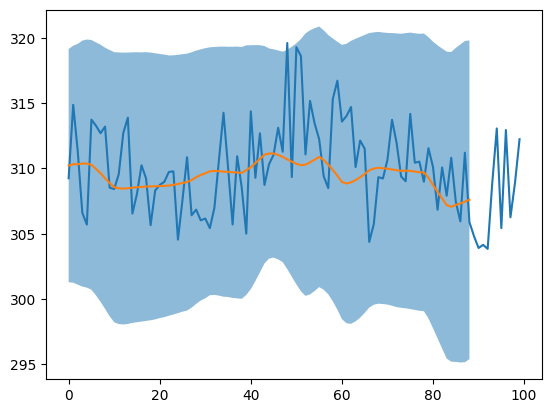

In [11]:
plt.plot(np.array(targets)[:100, 1])

plt.plot(means[:, 1])
plt.fill_between(np.arange(89), means[:, 1] - 2*np.sqrt(vars[:, 1]), means[:, 1] + 2*np.sqrt(vars[:, 1]), alpha=0.5)


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

InvalidIndexError: (slice(None, None, None), 0)

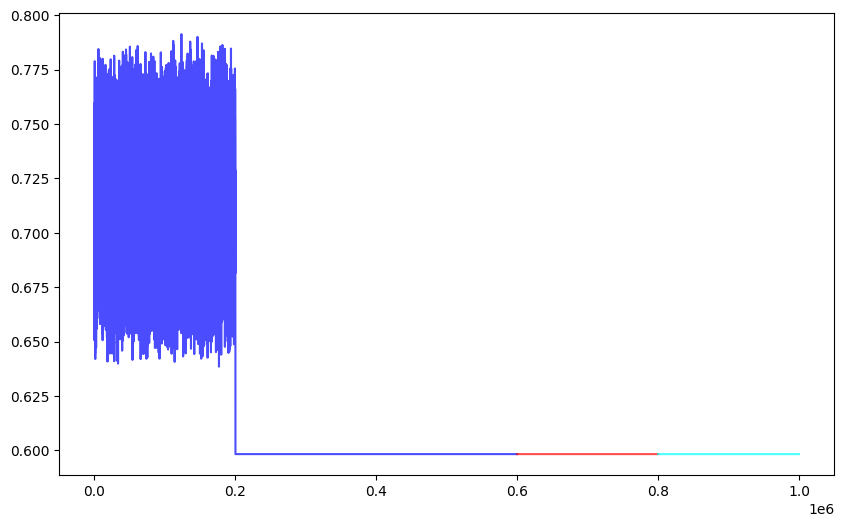

In [ ]:
# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
sequence_length = training_config.time_step
time_horizon = training_config.horizon
# For simplicity we will plot the first simulation
visualiser.plot_preds(means, features, noiseless_results, 
                            sequence_length, time_horizon, feature_names, num_simulations=10000,
                            train_test_split = training_config.train_test_split, test_val_split=training_config.test_val_split,
                            vars = vars)

In [ ]:
# Then we can plot this against the actions, to see the relationship between the actions/disturbances
# and the outputs
tgt_idxs = int((features.shape[1] - targets.shape[1]))
actions = features[:, -tgt_idxs:]
action_names = ['Inlet Temperature', 'Feed Concentration', 'Coolant Temperature']
# Use the plot actions class to compare the actions to the outputs
visualiser.plot_actions(actions, action_names, num_simulations=10)
# As there is no explicit control action, the setpoint is basically meaningless

We can also calculate the complexity of the model using the number of FLOPs

In [ ]:
import fvcore
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in model.parameters())}")

Can use Bayesian Optimisation to find the best hyperparameters for the model

In [ ]:
MLP_ConfigBounds = {
    # Training config bounds
    'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
    'num_epochs': (50, 500),
    'learning_rate': (0.0001, 0.1),
    'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
    'horizon': (1, 10),
    'weight_decay': (1e-6, 0.1),
    'factor': (0.1, 0.99),
    'patience': (5, 100),
    'delta': (1e-6, 0.1),   
    
    # MLP specific bounds
    'hidden_dim': (32, 512),
    'num_layers': (1, 50),
    'dropout': (0.1, 0.9),
    'activation': (0, 7),
}

In [ ]:
# Call the optimiser
optimiser = ModelOptimisation(model_class=MLP, sim_config=CSTR_Config,
                              train_config=training_config, model_config=MLP_Config,
                              config_bounds=MLP_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20, variance = True)

path = 'CSTR_MLP_NLL_Opt.pth'

best_params, best_loss = optimiser.optimise(path)
# The best performing model is saved automatically by the optimiser and can be loaded

After optimising the model, load the data

In [ ]:
# Load the optimised model
cp = torch.load(path)
print("Training configuration: ", cp['training_config'])
print("Model parameters: ", cp['model_config'])
model = MLP(cp['model_config'],
                     input_dim=X_train.shape[1],
                     output_dim=y_train.shape[1],
                     var = True
                     )
model.load_state_dict(cp['model_state_dict'])
# Then find the complexity of the model
flops = FlopCountAnalysis(model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in model.parameters())}")

In [ ]:
model.eval()
with torch.no_grad():
    train_mean, train_var = model(X_train.to(training_config.device))
    test_mean, test_var = model(X_test.to(training_config.device))

# Transform the predictions back to the original
rescaled_train_pred = data_processor.process_model_output(train_mean, train_var)
train_mean = rescaled_train_pred.mean
train_var = rescaled_train_pred.variance

rescaled_test_pred = data_processor.process_model_output(test_mean, test_var)
test_mean = rescaled_test_pred.mean
test_var = rescaled_test_pred.variance


y_train_orig, y_test_orig = scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)

# Plot the optimised predictions of the model
visualiser.plot_predictions(train_mean, test_mean, y_train_orig, y_test_orig, 
                            feature_names, num_simulations=10, 
                            train_var=train_var, test_var=test_var)

#### Aleatoric Uncertainty - Non Parametric; Quantile Regression
Can also use a non parametric approach, using Quantile (Pinball) loss to find uncertainty bounds

In [ ]:
MLP_Config = MLPConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    activation = 'ReLU'
)

quantiles = [0.25, 0.5, 0.75]

quantile_model = MLP(
    config = MLP_Config,
    input_dim = X_train.shape[1],
    output_dim = y_train.shape[1],
    quantiles = quantiles
)

# Train the model
criterion = QuantileLoss(quantiles)
trainer = ModelTrainer(quantile_model, training_config)
quantile_model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Optimise the model parameters and hyperparameters
# Call the optimiser
optimiser = ModelOptimisation(model_class=MLP, sim_config=CSTR_Config,
                              train_config=training_config, model_config=MLP_Config,
                              config_bounds=MLP_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=50, quantiles=quantiles)


path = 'CSTR_MLP_Quantile_Opt.pth'
best_params, best_loss = optimiser.optimise(path)


In [ ]:
path = 'CSTR_MLP_Quantile_Opt.pth'
cp = torch.load(path)
print("Training configuration: ", cp['training_config'])
print("Model parameters: ", cp['model_config'])
quantile_model = MLP(cp['model_config'],
                input_dim=X_train.shape[1],
                output_dim=y_train.shape[1],
                quantiles=quantiles
            )
quantile_model.load_state_dict(cp['model_state_dict'])

# Then find the complexity of the model
flops = FlopCountAnalysis(quantile_model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in quantile_model.parameters())}")

# Find the quantile_model predictions
quantile_model.eval()
with torch.no_grad():
    train_pred = quantile_model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = quantile_model(X_test.to(training_config.device)).cpu().numpy()

# Transform the quantile predictions back to the original
inverter = QuantileTransform(quantiles, scaler)
train_pred = inverter.inverse_transform(train_pred)
test_pred = inverter.inverse_transform(test_pred)

# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train_orig, y_test_orig, feature_names, num_simulations=10)